<a href="https://colab.research.google.com/github/soufianeodf/Quora-Insincere-Questions-Classification/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [163]:
import numpy as np
import pandas as pd
%matplotlib inline

train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/quora competition/train.csv')
train_df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [164]:
len(train_df)

1306122

### **Check for missing values:**

In [166]:
train_df.isnull().sum()

qid              0
question_text    0
target           0
dtype: int64

### **Check for empty strings:**

In [167]:
blanks = []  # start with an empty list

for i, qid, question_text, target in train_df.itertuples():  # iterate over the DataFrame
    if type(target)==str:            # avoid NaN values
        if target.isspace():         # test 'review' for whitespace
            blanks.append(i)     # add matching index numbers to the list
        
print(len(blanks), 'blanks: ', blanks)

0 blanks:  []


In [168]:
train_df['target'].value_counts()

0    1225312
1      80810
Name: target, dtype: int64

<font color=green>We see that 1225312 out of 1306122 questions, or 93.8%, are sincere questions.<br>This means that any machine learning model we create has to perform **better than 93.8%** to beat random chance.</font>

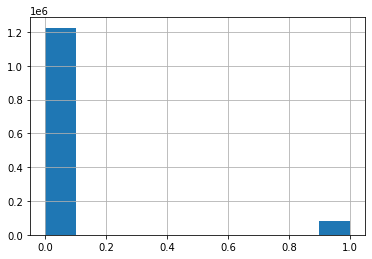

In [169]:
train_df['target'].hist(bins=10)

___
# Split the data into train & test sets:

## Selecting features

In [170]:
X = train_df['question_text']
y = train_df['target']

## Additional train/test/split arguments:
The default test size for `train_test_split` is 30%. Here we'll assign 33% of the data for testing.<br>
Also, we can set a `random_state`.

In [171]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print('Training Data Shape:', X_train.shape)
print('Testing Data Shape: ', X_test.shape)

Training Data Shape: (1175509,)
Testing Data Shape:  (130613,)


## Scikit-learn's CountVectorizer
Text preprocessing, tokenizing and the ability to filter out stopwords are all included in [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html), which builds a dictionary of features and transforms documents to feature vectors.

In [172]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()

X_train_counts = count_vect.fit_transform(X_train)
X_train_counts.shape

(1175509, 184450)

## Transform Counts to Frequencies with Tf-idf
While counting words is helpful, longer documents will have higher average count values than shorter documents, even though they might talk about the same topics.

To avoid this we can simply divide the number of occurrences of each word in a document by the total number of words in the document: these new features are called **tf** for Term Frequencies.

Another refinement on top of **tf** is to downscale weights for words that occur in many documents in the corpus and are therefore less informative than those that occur only in a smaller portion of the corpus.

This downscaling is called **tf–idf** for “Term Frequency times Inverse Document Frequency”.

Both tf and tf–idf can be computed as follows using [TfidfTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html):

In [173]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()

X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(1175509, 184450)

Note: the `fit_transform()` method actually performs two operations: it fits an estimator to the data and then transforms our count-matrix to a tf-idf representation.

## Combine Steps with TfidVectorizer
In the future, we can combine the CountVectorizer and TfidTransformer steps into one using [TfidVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html):

In [174]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

X_train_tfidf = vectorizer.fit_transform(X_train) # remember to use the original X_train set
X_train_tfidf.shape

(1175509, 184450)

## Train a Classifier
Here we'll introduce an SVM classifier, called [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html). LinearSVC handles sparse input better, and scales well to large numbers of samples.

In [175]:
from sklearn.svm import LinearSVC
clf = LinearSVC()
clf.fit(X_train_tfidf,y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

## Build a Pipeline
Remember that only our training set has been vectorized into a full vocabulary. In order to perform an analysis on our test set we'll have to submit it to the same procedures. Fortunately scikit-learn offers a [**Pipeline**](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) class that behaves like a compound classifier.

In [176]:
from sklearn.pipeline import Pipeline

text_clf = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', LinearSVC()),
])

# Feed the training data through the pipeline
text_clf.fit(X_train, y_train)  

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
               

## Test the classifier and display results

In [177]:
# Form a prediction set
predictions = text_clf.predict(X_test)

In [178]:
# Report the confusion matrix
from sklearn import metrics
print(metrics.confusion_matrix(y_test,predictions))

[[121204   1544]
 [  4280   3585]]


In [179]:
# Print a classification report
print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98    122748
           1       0.70      0.46      0.55      7865

    accuracy                           0.96    130613
   macro avg       0.83      0.72      0.76    130613
weighted avg       0.95      0.96      0.95    130613



In [180]:
# Print the overall accuracy
print(metrics.accuracy_score(y_test,predictions))

0.9554102577844472
